**Изучение ансамблей решающих деревьев**

Использьвание алгоритма - решающее дерево может приводить к высокой дисперисии предсказаний. Для того, чтобы это избежать исползуются методы, которые обощают под названием ансамбли решающих деревьев. Выделяют следующие методы:

- Bagging;
- Random Forests;
- Boosting;
- Bayesian Additive Regression Trees.

**Источники**

- <a href="https://hastie.su.domains/ISLR2/ISLRv2_website.pdf">ISLR</a>;
- <a herf="https://hastie.su.domains/ISLR2/ISLRv2_website.pdf">Собрание возможностей sklearn посвященных ансамблям</a>;

In [1]:
from copy import copy
import warnings

import pandas as pd
import numpy as np

from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.model_selection import cross_val_score

from tqdm import tqdm

import matplotlib.pyplot as plt

# Баггинг

Предполагает бутстрапирование обучающей выборки и подгонку множестава деревьев. Для получания предсказаний результаты каждого дерева аггрегируют (обычно усредняют). Вообще говоря, баггинг можно ложить не только на деревья но и на KNN модели.

### *Сравнение с единичным деревом*

Создам выборку и на ней попробую оценить обычное дерево и баггинг на дереве. Результаты сравним.

In [2]:
sample_size = 500
np.random.seed(10)

data = pd.DataFrame({
    "x" : np.random.rand(sample_size)
})

f_x = lambda x: 15*x**3 - 15*x**2 + x 

data["y"] = f_x(data["x"]) + np.random.uniform(0, 1, sample_size)

Для контроля глубины дерева будет использоватся алгоритм обрезки с учетом сложности затрат. Для того, надо подобрать его парамерт $\alpha$.

In [3]:
ccp_alphas = DecisionTreeRegressor().\
cost_complexity_pruning_path(
    data[["x"]], data["y"]
)["ccp_alphas"]

clf = DecisionTreeRegressor()
MSEs = {}

for alpha in tqdm(ccp_alphas):
    clf.set_params(ccp_alpha = alpha)
    MSE = cross_val_score(
        clf, data[["x"]], 
        data["y"], 
        cv = 20,
        scoring = "neg_mean_squared_error"
    )
    MSEs[alpha] = MSE

MSEs = pd.DataFrame(MSEs)

100%|██████████| 345/345 [00:21<00:00, 15.69it/s]


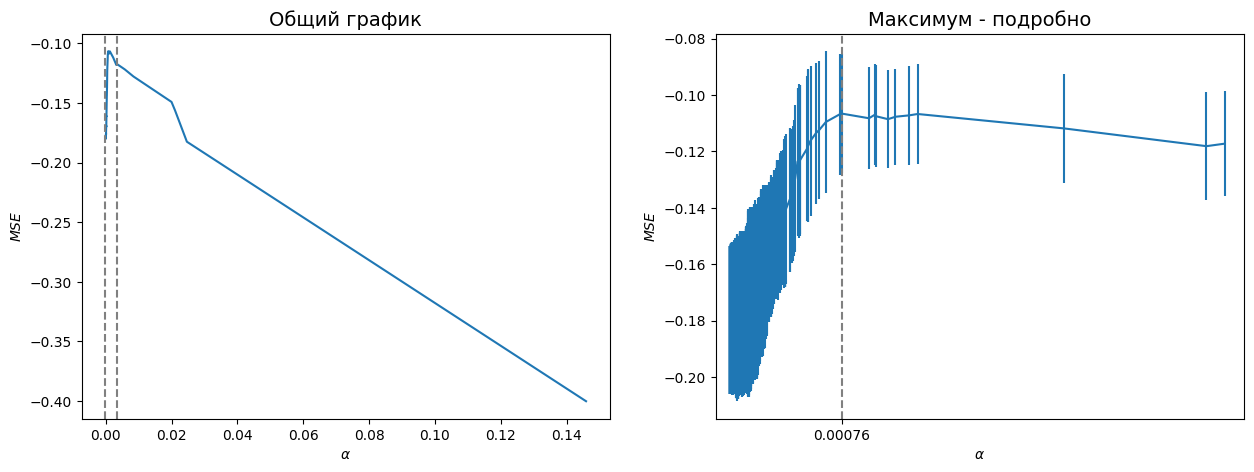

In [4]:
plt.figure(figsize = [15, 5])

def set_params():
    plt.xlabel("$\\alpha$")
    plt.ylabel("$MSE$")

bordres = [-0.0001, 0.0035]

plt.subplot(121)
plt.plot(MSEs.columns, MSEs.mean())
set_params()
for b in bordres:
    plt.axvline(b, color = "gray", linestyle = "dashed")
plt.title("Общий график", fontsize = 14)


cond = (MSEs.columns > bordres[0]) & (MSEs.columns < bordres[1])

plt.subplot(122)
plt.errorbar(MSEs.columns[cond], MSEs.mean()[cond], MSEs.std()[cond])
plt.axvline(
    MSEs.mean().idxmax(), 
    color = "gray", 
    linestyle = "dashed"
)
plt.xlim(bordres)
set_params()
plt.title("Максимум - подробно", fontsize = 14)
plt.xticks([MSEs.mean().idxmax()])

del set_params

Теперь подгоням которые будем сравнивать.

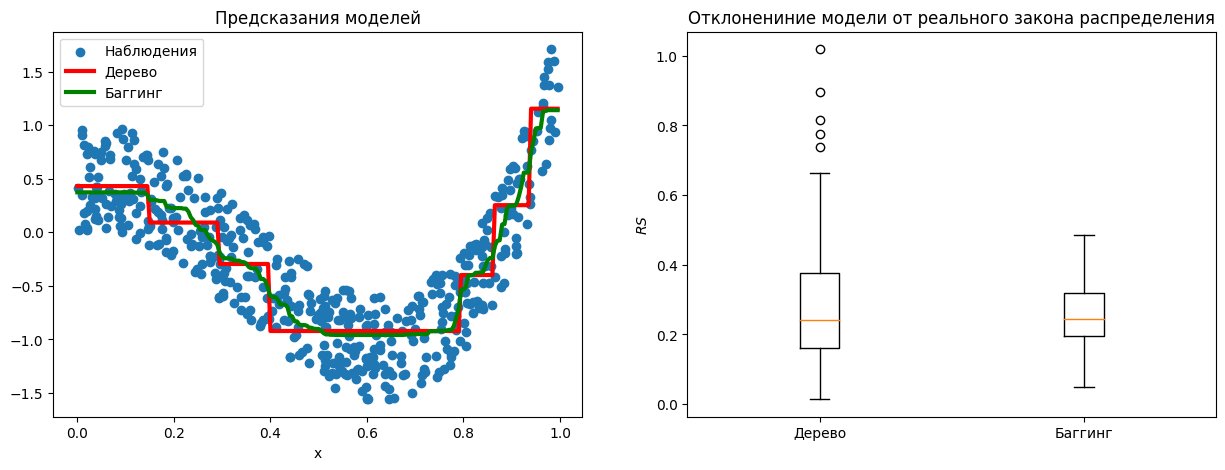

In [5]:
x_range = np.arange(0, 1, 0.005)

clf = DecisionTreeRegressor(ccp_alpha=0.0076)
clf.fit(data[["x"]].to_numpy(), data["y"])
tree_predict = clf.predict(x_range[:, np.newaxis])

bclf = BaggingRegressor(clf, n_estimators=200).fit(
    data[["x"]].to_numpy(), data["y"]
)
bagging_predict = bclf.predict(x_range[:, np.newaxis])

plt.figure(figsize = [15, 5])

plt.subplot(121)
plt.scatter(data["x"], data["y"])
for pred, col in zip(
    [tree_predict, bagging_predict],
    ["red", "green"]
):
    plt.plot(
        x_range, pred,
        color = col, linewidth = 3
    )

plt.legend(["Наблюдения", "Дерево", "Баггинг"])
plt.title("Предсказания моделей")
plt.xlabel("x")

plt.subplot(122)
plt.boxplot((
    (f_x(x_range) - tree_predict)**2, 
    (f_x(x_range) - bagging_predict)**2)
)

plt.title("Отклонениние модели от реального закона распределения")
plt.ylabel("$RS$")
ans = plt.xticks([1,2], ["Дерево", "Баггинг"])

Все складывается так, что баггированная модель "сглаживает" неготорые скачки, которые проявляются в одиночном дереве. В результате квадраты остатков (которые описывает правый график) более тучные для баггинга - меньше болших оклонений вверх но и нижняя граница выше.

# Случайный лес (Random Forest)

Идея как у баггинга, но, кроме того, что каждая подвыборка содержит только $m$ из $p$ случайных показателей. Обычно берут $m = \sqrt{p}$. А в остальном особой разницы нет.

Если в выборке есть очень сильные показатели, то первое деление дерева производится часто именно по нему. В результате простой баггинг от подвыборки к подвыборке имеет очень похожие результаты. Случайное дерево справляется с этой ситуацией лучше.

# OOB

OOB - out of bag. Способ оценки качества ансамблей моделей, при котором, оценка метрики качества модели производится на том "кусочке" выборке который не был задейсвован при обучении конкретной модели. Затем полученные величины, собранные со всей выборки агрегируют - полученное число и становится результатом.

### Пример на котором будем экспериментировать

In [6]:
# делаю пример классификационной задачи
np.random.seed(50)

# vector of coefs of the discriminating curve (as a polynom)
coefs = np.array([0.40740741, -4.44444444, 13.88888889, -9.25925926])

def compute_poly_for_np_array(array, coefs):
    '''
        Calculation of the polynomial for an numpy array.
        Inputs:
            array - an array of any dimension to be used as an argument of the polynom;
            coefs - polynomial coefficients (i-th for i degree);
        Output numpy.array with gived same dimentions as array.
    '''
    
    poly_degree = len(coefs)
    return np.sum(
        [coefs[i]*(array**i) for i in range(poly_degree)], 
        axis = 0
    )

# transition speed from one class to another
trans_speed = 4
def prob_for_bayes(x1, x2):
    '''
        This function describes a Bayesian 
        law that is used to divide into classes.
        Inputs:
            x1 - coordinate of first variable;
            x2 - coordiante of second variable;
        Output:
            p - probability that observation takes class 1 
                for given coordinates.
    '''
    return 1/(1 + np.exp(trans_speed*(compute_poly_for_np_array(x1, coefs) - x2)))



def create_sample():
    '''
        Создать случайную выборку, в соответсвии с
        заданным законом распределения
    '''

    df = pd.DataFrame(
        np.random.rand(1000, 2),
        columns = ["x1", "x2"]
    )
    df["prob"] = prob_for_bayes(df["x1"], df["x2"])
    df["class"] = df["prob"].apply(
        lambda p: np.random.choice([0, 1], p = [1-p, p])
    )

    return df


# создание выборки - примера
np.random.seed(50)
df = create_sample()

# создание сетки
x1_range = np.linspace(0, 1, 500)
x2_range = np.linspace(0, 1, 500)

x1_mesh, x2_mesh = np.meshgrid(x1_range, x2_range)
mesh_df = pd.DataFrame({
    "x1" : x1_mesh.ravel(), "x2" : x2_mesh.ravel()
})

real_prob = prob_for_bayes(mesh_df["x1"], mesh_df["x2"]).to_numpy()
real_prob = real_prob.reshape(x1_mesh.shape)

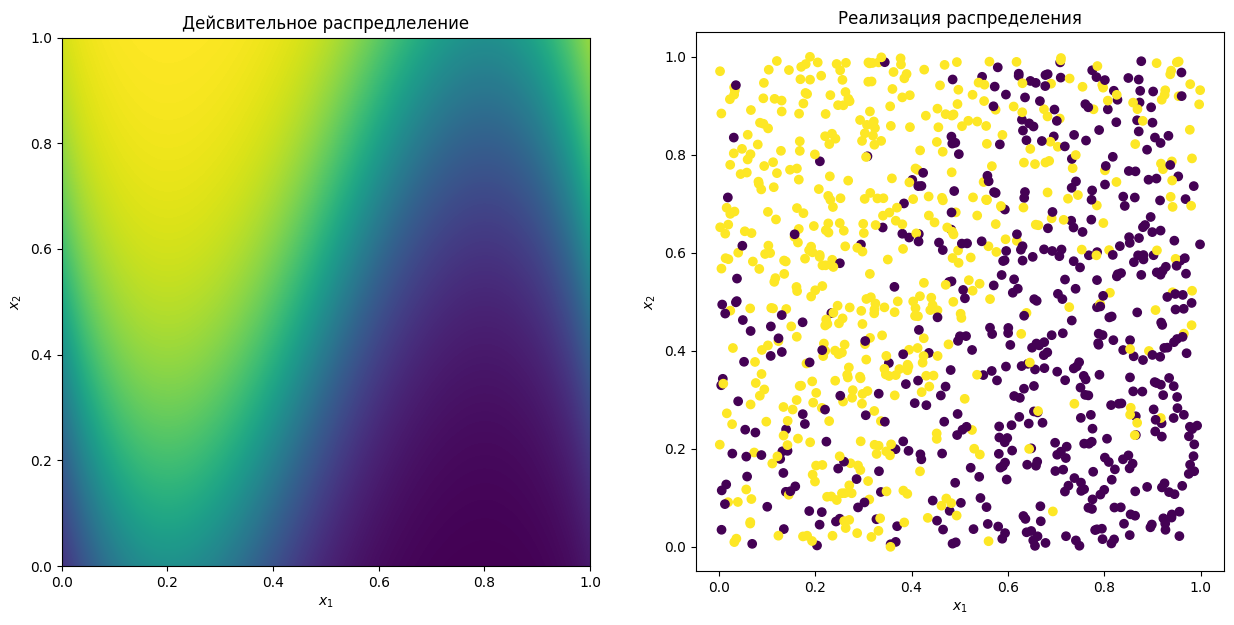

In [7]:
plt.figure(figsize = [15, 7])

plt.subplot(121)
plt.imshow(real_prob, origin = "lower", extent = [0, 1, 0, 1])
plt.title("Дейсвительное распредлеление")
plt.xlabel("$x_1$"); plt.ylabel("$x_2$");

plt.subplot(122)
plt.scatter(df["x1"], df["x2"], c=df["class"])
plt.xlabel("$x_1$"); plt.ylabel("$x_2$");
ans = plt.title("Реализация распределения")

### Реализация в sklearn


sklearn умеет OOB, но из метрик доступна только accuracy (доля правильно предсказанных), это тупо захардкожено <a href="https://github.com/scikit-learn/scikit-learn/blob/0fb307bf39bbdacd6ed713c00724f8f871d60370/sklearn/ensemble/_forest.py#L547">тут</a>. Например, можно провести oob для баггинга используя параметр `oob_score = True` констуктора класса `BaggingClassifier`. Ну а после обучения получить поле `oob_score_` полученного объекта.

In [8]:
clf = BaggingClassifier(
    DecisionTreeClassifier(ccp_alpha = 0.01),
    n_estimators=30,
    oob_score=True,
    random_state=50,
).fit(df[["x1", "x2"]], df["class"])

clf.oob_score_

0.747

Интересное поле - `oob_decision_function_`. В исходние получается, что это среднее предсказание для каждого наблюдения, из всех его попаданий вне обучающей выборки. На нем при желании можно оценивать AUC.

In [9]:
clf.oob_decision_function_

array([[0.47801078, 0.52198922],
       [0.35901744, 0.64098256],
       [0.12722208, 0.87277792],
       ...,
       [0.15777634, 0.84222366],
       [0.89753659, 0.10246341],
       [0.86331456, 0.13668544]])

Интерестно, что если для каждого наблюдения сформировать предсказание и сравнить среднюю точность с `oob_score_`, то всегда будет получаться одно и тоже число. Хотя в коде sklearn `oob_score_` вычисляется подругому. Если будет совсем нечего делать, можно попробовать разобраться почему так происходит.

In [10]:
# частный случай пример 
(df["class"].to_numpy() == np.argmax(clf.oob_decision_function_, axis=1)).mean()

0.747

In [11]:
# 20 других частных случаев
lst = []

for i in range(20):
    temp_df = create_sample()

    temp_clf = BaggingClassifier(
        DecisionTreeClassifier(ccp_alpha = 0.01),
        n_estimators=30,
        oob_score=True,
        random_state=50,
    ).fit(temp_df[["x1", "x2"]], temp_df["class"])

    comp = (
        temp_df["class"].to_numpy() == \
        np.argmax(temp_clf.oob_decision_function_, axis=1)
    ).mean()

    lst.append(comp == temp_clf.oob_score_)

all(lst)

True

### Сравнение cv и oob 

In [12]:
def fit_estimate(X, y, ccp, n_estimators):

    # приходится отключить warnings потому, что bagging
    # ругается в случае малого числа оценщиков
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    clf = BaggingClassifier(
        DecisionTreeClassifier(ccp_alpha = ccp),
        n_estimators=n_estimators,
        oob_score=True,
        random_state=50,
    )

    cv_score = cross_val_score(
        clf, X, y, scoring="accuracy", cv = 20
    )
    res = cv_score.mean(), clf.fit(X,y).oob_score_
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=RuntimeWarning

    return res

def get_best_model(scores):
    '''
        Получить лучшую модель.
        Под лучшей понимается модель, с самым высоким 
        значением целевой метрики, но при этом с 
        минимальными возможными числом оценщиков 
        и глубиной дерева.

        Input:
            scores - pandas.Series который содержит занчения целевой
                     метрики, а в колонках у него:
                        "n_estimators" - число оценщиков соответсвующей модели;
                        "ccp" - параметр обрезки дерева.
        Output - та строка из scores в которой заданы параметры
                 наилучшей модели.
    '''

    main_val = scores.name
    return scores.reset_index().sort_values(
        [main_val, "n_estimators", "ccp"], 
        ascending=[False, True, False]
    ).iloc[0]

# создание тех комбинаций
# параметров модели которое нужно
# осчитать
ccp_alphas = DecisionTreeRegressor().\
cost_complexity_pruning_path(
    df[["x1", "x2"]], df["class"]
)["ccp_alphas"]

ccp_alphas = np.linspace(ccp_alphas.min(), ccp_alphas.max(), 10)
estimator_counts = range(30, 70)

combinations = pd.DataFrame(
    [col.ravel() for col in np.meshgrid(ccp_alphas, estimator_counts)],
    index=["ccp", "n_estimators"]
).T

SyntaxError: '(' was never closed (1082649026.py, line 19)

In [ ]:
val_ress = pd.read_csv("cv_vs_oob.csv", index_col=[0, 1])

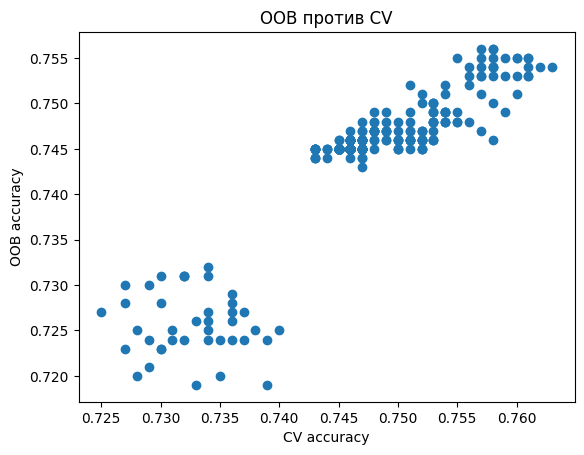

In [ ]:
plt.scatter(val_ress["cross validation"], val_ress["OOB"])
plt.xlabel("CV accuracy")
plt.title("OOB против CV")
ans = plt.ylabel("OOB accuracy")

In [ ]:
pd.concat(
    [
        get_best_model(val_ress["cross validation"]),
        get_best_model(val_ress["OOB"])
    ],
    axis=1
)

,281,201
ccp,0.006929,0.006929
n_estimators,58.000000,50.000000
cross validation,0.763000,NaN
OOB,NaN,0.756000


# ООб

In [10]:
heart = pd.read_csv("Heart.csv", index_col=0)

y = (heart["AHD"] == "Yes").astype("int32")
X = pd.get_dummies(heart.drop("AHD", axis=1))

X_train = X.iloc[:152]
X_test = X.loc[~X.index.isin(X_train.index)]
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]

clf = RandomForestClassifier()
for tree_count in range(1,301):
    clf.set_params()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable
153,67,0,115,564,0,2,160,0,1.6,2,0.0,False,True,False,False,False,False,True
154,55,1,160,289,0,2,145,1,0.8,2,1.0,True,False,False,False,False,False,True
155,64,1,120,246,0,2,96,1,2.2,3,1.0,True,False,False,False,False,True,False
156,70,1,130,322,0,2,109,0,2.4,2,3.0,True,False,False,False,False,True,False
157,51,1,140,299,0,0,173,1,1.6,1,0.0,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,45,1,110,264,0,0,132,0,1.2,2,0.0,False,False,False,True,False,False,True
300,68,1,144,193,1,0,141,0,3.4,2,2.0,True,False,False,False,False,False,True
301,57,1,130,131,0,0,115,1,1.2,2,1.0,True,False,False,False,False,False,True
302,57,0,130,236,0,2,174,0,0.0,2,1.0,False,False,True,False,False,True,False
